# Loan Default Risk

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.ensemble import VotingClassifier
from joblib import dump, load

In [2]:
def plot_var(col_name, title, continuous, dataset, x1limit=False, x2limit=False, x1l=0, x1u=0, x2l=0, x2u=0):
    """
    Plot a variable against the response variable loan status
    - col_name is the variable name in the dataframe
    - title is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    - dataset is the pandas dataframe containing the dataset
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)

    # Plot without loan status
    if continuous:
        sns.distplot(dataset.loc[dataset[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(dataset[col_name], order=sorted(dataset[col_name].unique()), color='#4f81bd', saturation=1, ax=ax1)
    if x1limit:
        ax1.set_xlim([x1l, x1u])
    ax1.set_xlabel(title)
    ax1.set_ylabel('Frequency')
    ax1.set_title(title)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=dataset, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(title + ' by Loan Status')
    else:
        charge_off_rates = dataset.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#4f81bd', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + title)
    if x2limit:
        ax2.set_xlim([x2l, x2u])
    ax2.set_xlabel(title)

    plt.tight_layout()


# Preliminary Data Analysis

In [3]:
# read in the entire raw dataset
dataset = pd.read_csv('.\\data\\Loan Data 2017Q2 Clean.csv', header=0)
# pd.set_option('display.max_columns', None)

In [4]:
dataset.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000,36 months,7.35%,155.19,A,5 years,MORTGAGE,60000.0,Not Verified,Fully Paid,...,Oct-04,12,0,3697,13.20%,25,w,Individual,1,0
1,7500,36 months,7.35%,232.79,A,7 years,MORTGAGE,110000.0,Not Verified,Fully Paid,...,Mar-13,19,0,23348,27.20%,27,w,Individual,4,0
2,9600,36 months,7.97%,300.70,A,< 1 year,OWN,140000.0,Not Verified,Fully Paid,...,Aug-05,16,0,11808,48.60%,44,w,Individual,3,0
3,2000,36 months,7.07%,61.82,A,2 years,RENT,80000.0,Not Verified,Fully Paid,...,Apr-05,9,0,38,0.30%,12,w,Individual,0,0
4,7200,36 months,24.85%,285.70,E,2 years,RENT,50000.0,Source Verified,Fully Paid,...,Jan-00,4,0,3560,98.90%,5,w,Individual,0,0


In [5]:
# Look at how many of each response variable we have
print(dataset['loan_status'].value_counts(dropna=False))
print(dataset['loan_status'].value_counts(normalize=True, dropna=False))
print(dataset.shape)

Fully Paid     29145
Charged Off     8625
Name: loan_status, dtype: int64
Fully Paid     0.771644
Charged Off    0.228356
Name: loan_status, dtype: float64
(37770, 23)


| Status     | Count | Percentage |
| -----------|:-----:|:----------:|
| Fully Paid | 29145 | 77% |
| Charged Off | 8625 | 23% |

37770 rows x 25 Columns

A list of percentage of missing values in a column

In [6]:
missing_values = ((dataset.isna().sum()) / len(dataset.index)).sort_values(ascending=False)
missing_values[missing_values > 0]

emp_length    0.065078
revol_util    0.000688
dti           0.000635
dtype: float64

In [7]:
# Look at the data type of each column
print(dataset.dtypes)

loan_amnt                 int64
term                     object
int_rate                 object
installment             float64
grade                    object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
dti                     float64
delinq_2yrs               int64
earliest_cr_line         object
open_acc                  int64
pub_rec                   int64
revol_bal                 int64
revol_util               object
total_acc                 int64
initial_list_status      object
application_type         object
mort_acc                  int64
pub_rec_bankruptcies      int64
dtype: object


| Variable | Type |
| ---------|:----:|
| Loan Amount | Numerical |
| Term | Categorical |
| Interest Rate | Numerical |
| Installment | Numerical |
| Grade | Categorical |
| Employment Length | Numerical |
| Home Ownership | Categorical |
| Annual Income | Numerical |
| Verification Status | Categorical |
| Loan Status| Categorical |
| Purpose | Categorical |
| Debt-to-Income Ratio | Numerical |
| Delinquency | Categorical |
| Earliest Credit Line | Numerical |
| Open Accounts | Numerical |
| Public Records | Categorical |
| Revolving Balance | Numerical |
| Revolving Utility | Numerical |
| Total Account | Numerical |
| Initial List Status | Categorical |
| Application Type | Categorical |
| Mortage Account | Numerical |
| Public Record of Bankruptcies | Categorical |

# Exploratory Data Analysis

### Annual Income (Numerical)
The self-reported annual income provided by the borrower during registration

In [8]:
print(dataset.groupby('loan_status')['annual_inc'].describe())



               count          mean           std  min      25%      50%  \
loan_status                                                               
Charged Off   8625.0  73189.649769  46186.090717  0.0  45000.0  63000.0   
Fully Paid   29145.0  80899.315013  69096.968024  0.0  49000.0  69000.0   

                 75%        max  
loan_status                      
Charged Off  90000.0   900000.0  
Fully Paid   97133.0  5616890.0  


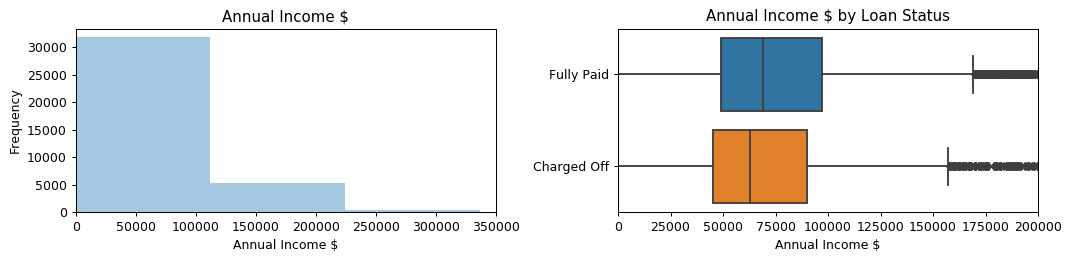

In [9]:
plot_var('annual_inc', 'Annual Income $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=-1, x1u=350000, x2l=-1, x2u=200000)

In [10]:
# Because the plot is right skewed we take a log transform of the annual income
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log(x + 1))
dataset.drop('annual_inc', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_annual_inc'].describe())

               count       mean       std  min        25%        50%  \
loan_status                                                            
Charged Off   8625.0  11.046253  0.602620  0.0  10.714440  11.050906   
Fully Paid   29145.0  11.129532  0.625351  0.0  10.799596  11.141876   

                   75%        max  
loan_status                        
Charged Off  11.407576  13.710151  
Fully Paid   11.483847  15.541289  


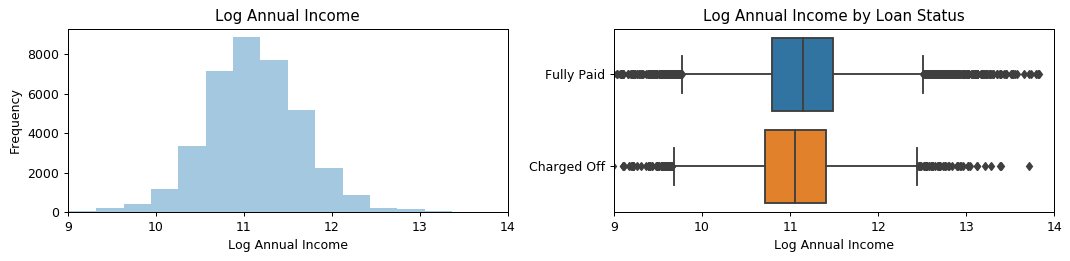

In [11]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=9, x1u=14, x2l=9, x2u=14)

It seems that those with higher annual income are less risk

### Application Type (Categorical)
Indicates whether the loan is an individual application or a joint application with two co-borrowers

loan_status  application_type
Charged Off  Individual           8073
             Joint App             552
Fully Paid   Individual          27609
             Joint App            1536
Name: application_type, dtype: int64


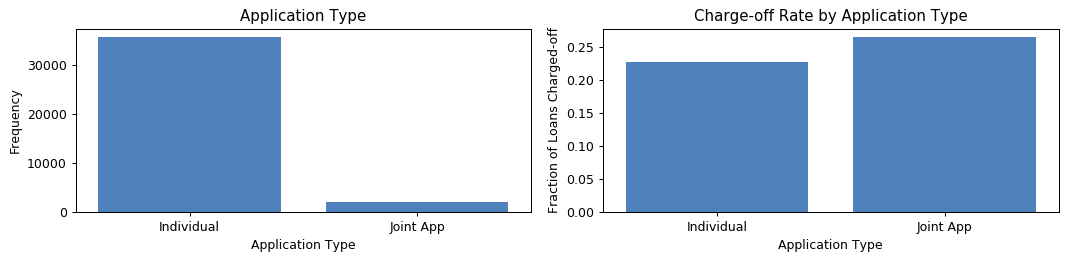

In [12]:
print(dataset.groupby('loan_status')['application_type'].value_counts(dropna=False))
plot_var('application_type', 'Application Type', continuous=False, dataset=dataset)

There does not seem to be a strong correlation between risk and application_type. Both risk around the same percentage.

### Debt to Income Ratio (Numerical)
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

               count       mean        std  min    25%     50%    75%    max
loan_status                                                                 
Charged Off   8620.0  20.538085  11.553504  0.0  13.86  20.185  26.55  532.0
Fully Paid   29126.0  18.066659  13.751295  0.0  11.48  17.190  23.52  999.0


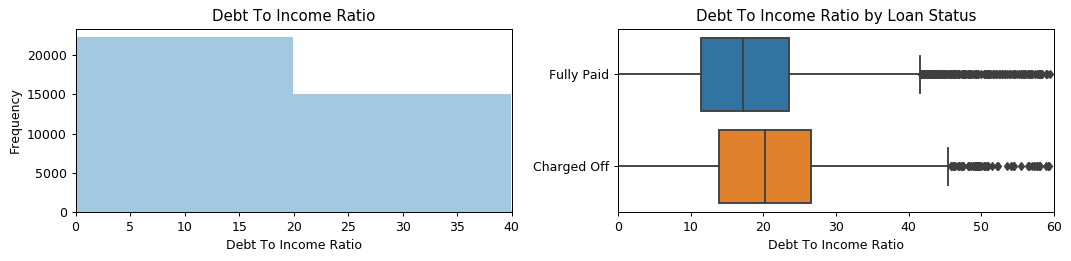

In [13]:
# dummy = dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti']
print(dataset.groupby('loan_status')['dti'].describe())
plot_var('dti', 'Debt To Income Ratio', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=60)
# sns.distplot(dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti'], kde=False)
# plt.xlabel('Debt-to-income Ratio')
# plt.ylabel('Count')
# plt.title('Debt-to-income Ratio')

It seems that a higher debt to income ratio has a higher probability of charged off

### Delinquency (Categorical)
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

loan_status  delinq_2yrs
Charged Off  0               6756
             1               1206
             2                663
Fully Paid   0              23444
             1               3817
             2               1884
Name: delinq_2yrs, dtype: int64


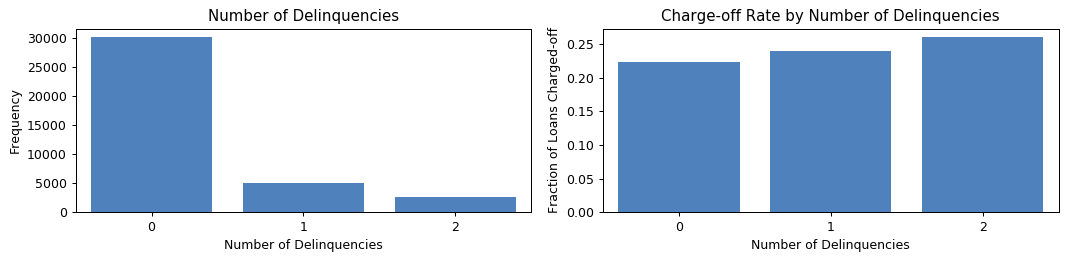

In [14]:
dataset['delinq_2yrs'].values[dataset['delinq_2yrs'] > 1] = 2
print(dataset.groupby('loan_status')['delinq_2yrs'].value_counts(dropna=False))
plot_var('delinq_2yrs', 'Number of Delinquencies', continuous=False, dataset=dataset)

There seems to be an increasing trend in charge-off rate and increasing number of delinquencies but it is small. Whether or not this is significant remains to be seen.

### Earliest Credit Line (Numerical)
The month the borrower's earliest reported credit line was opened.

               count         mean       std     min     25%     50%     75%  \
loan_status                                                                   
Charged Off   8625.0  2001.169855  7.686851  1957.0  1998.0  2003.0  2006.0   
Fully Paid   29145.0  2000.470647  7.565745  1958.0  1997.0  2002.0  2005.0   

                max  
loan_status          
Charged Off  2014.0  
Fully Paid   2014.0  


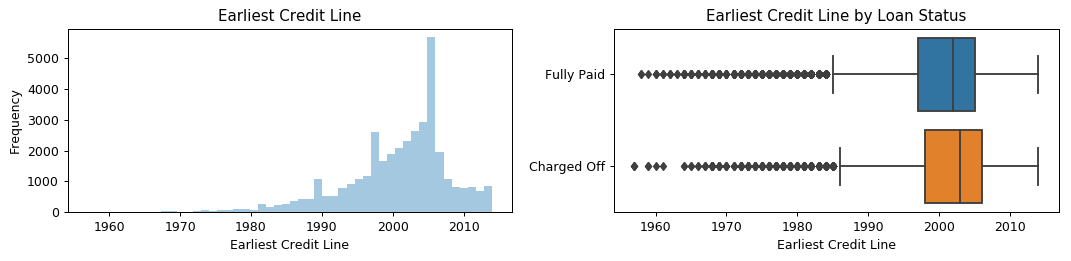

In [15]:
# dataset['earliest_cr_line'] = pd.to_datetime(dataset['earliest_cr_line'], format='%b-%y').dt.year
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-2:]))
dataset.loc[dataset['earliest_cr_line'] > 20, 'earliest_cr_line'] += 1900
dataset.loc[dataset['earliest_cr_line'] < 20, 'earliest_cr_line'] += 2000
print(dataset.groupby('loan_status')['earliest_cr_line'].describe())
plot_var('earliest_cr_line', 'Earliest Credit Line', continuous=True, dataset=dataset)

It seems that those with an earlier credit line are more likely to be less risk

### Employment Length (Numerical)
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

loan_status  emp_length
Charged Off  0.0             840
             1.0             611
             2.0             853
             3.0             743
             4.0             517
             5.0             506
             6.0             305
             7.0             304
             8.0             285
             9.0             287
             10.0           2609
             NaN             765
Fully Paid   0.0            2454
             1.0            1879
             2.0            2654
             3.0            2349
             4.0            1793
             5.0            1788
             6.0            1311
             7.0            1054
             8.0             856
             9.0            1101
             10.0          10213
             NaN            1693
Name: emp_length, dtype: int64


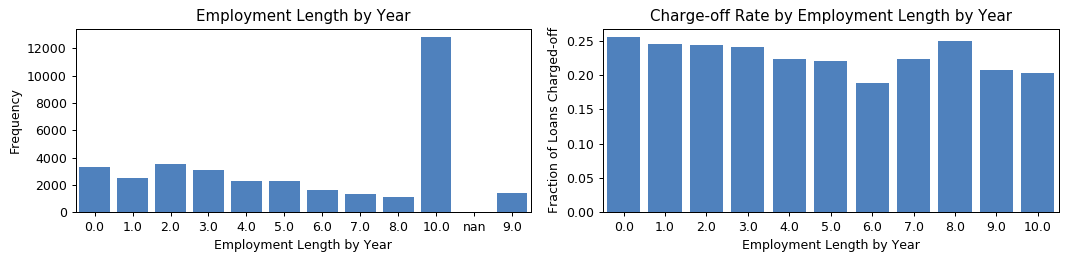

In [16]:
dataset['emp_length'].replace('< 1 year', 0, inplace=True)
dataset['emp_length'].replace('1 year', 1, inplace=True)
dataset['emp_length'].replace('2 years', 2, inplace=True)
dataset['emp_length'].replace('3 years', 3, inplace=True)
dataset['emp_length'].replace('4 years', 4, inplace=True)
dataset['emp_length'].replace('5 years', 5, inplace=True)
dataset['emp_length'].replace('6 years', 6, inplace=True)
dataset['emp_length'].replace('7 years', 7, inplace=True)
dataset['emp_length'].replace('8 years', 8, inplace=True)
dataset['emp_length'].replace('9 years', 9, inplace=True)
dataset['emp_length'].replace('10+ years', 10, inplace=True)
print(dataset.groupby('loan_status')['emp_length'].value_counts(dropna=False).sort_index())
plot_var('emp_length', 'Employment Length by Year', continuous=False, dataset=dataset)

Doesn't seem to be much of a significant pattern here

### Home Ownership (Categorical)
The home ownership status provided by the borrower during registration or obtained from the credit report.

loan_status  home_ownership
Charged Off  RENT               3932
             MORTGAGE           3654
             OWN                1039
Fully Paid   MORTGAGE          15651
             RENT              10149
             OWN                3345
Name: home_ownership, dtype: int64


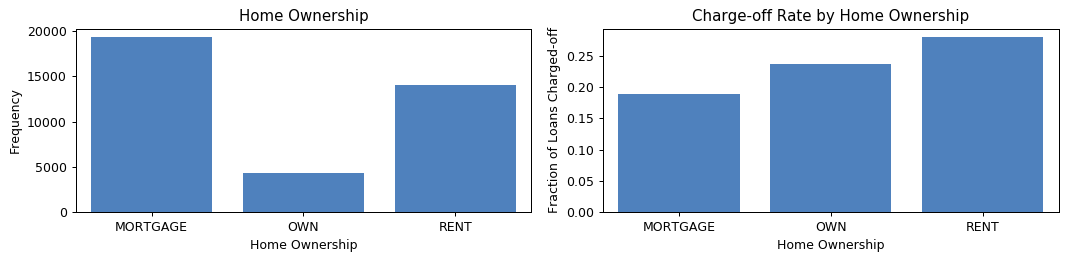

In [17]:
# dataset['home_ownership'].replace(['NONE', 'ANY'], 'NaN', inplace=True)
print(dataset.groupby('loan_status')['home_ownership'].value_counts(dropna=False))
plot_var('home_ownership', 'Home Ownership', continuous=False, dataset=dataset)
# dataset['home_ownership'].replace('NaN', np.nan, inplace=True)

Interestingly those with a mortgage are more likely to pay off loans and those who rent are the least likely

### Initial List Status (Categorical)
The initial listing status of the loan. Possible values are – W, F

loan_status  initial_list_status
Charged Off  w                       5999
             f                       2626
Fully Paid   w                      21390
             f                       7755
Name: initial_list_status, dtype: int64


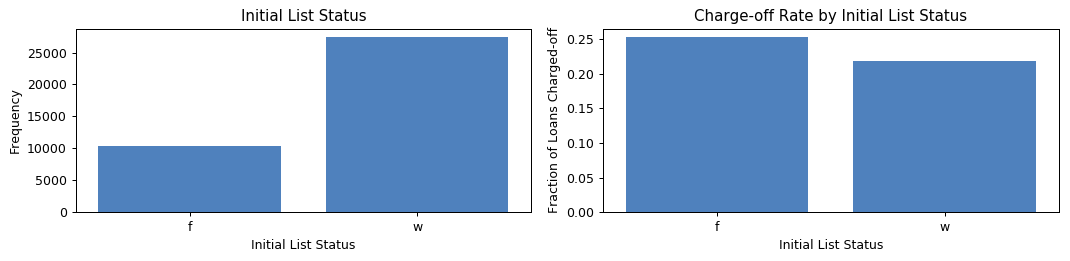

In [18]:
print(dataset.groupby('loan_status')['initial_list_status'].value_counts(dropna=False))
plot_var('initial_list_status', 'Initial List Status', continuous=False, dataset=dataset)

Theres does not seem to be much information gained from Initial List status

### Installment (Numerical)
The monthly payment owed by the borrower if the loan originates.

In [19]:
print(dataset.groupby('loan_status')['installment'].describe())

               count        mean         std    min     25%     50%     75%  \
loan_status                                                                   
Charged Off   8625.0  483.633490  300.351212  31.04  263.78  398.52  649.96   
Fully Paid   29145.0  420.773546  281.422908  30.12  212.75  341.41  559.44   

                 max  
loan_status           
Charged Off  1566.80  
Fully Paid   1587.23  


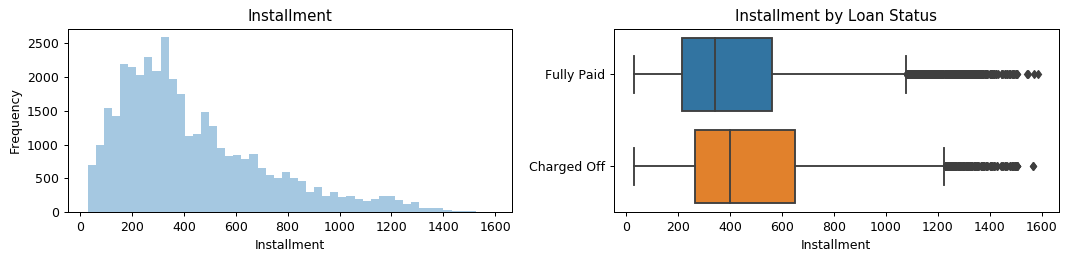

In [20]:
plot_var('installment', 'Installment', continuous=True, dataset=dataset)

In [21]:
# since the plot is left skewed, we take the log transformation
dataset['log_installment'] = dataset['installment'].apply(lambda x: np.log(x + 1))
dataset.drop('installment', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_installment'].describe())

               count      mean       std       min       25%       50%  \
loan_status                                                              
Charged Off   8625.0  5.975791  0.685506  3.466985  5.578899  5.990264   
Fully Paid   29145.0  5.811583  0.722315  3.437851  5.364807  5.836009   

                  75%       max  
loan_status                      
Charged Off  6.478448  7.357429  
Fully Paid   6.328722  7.370375  


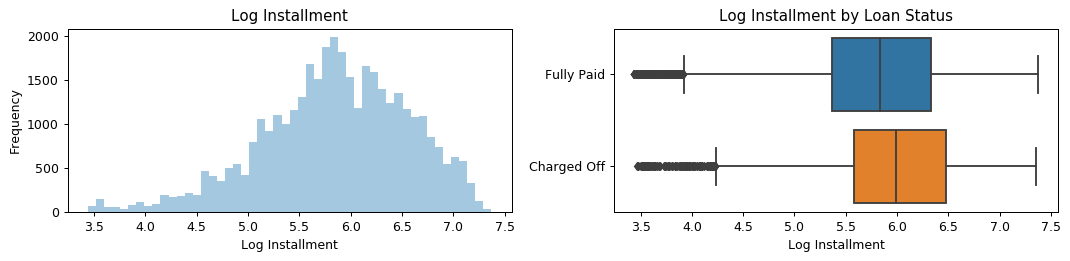

In [22]:
plot_var('log_installment', 'Log Installment', continuous=True, dataset=dataset)

It seems those with higher installments are more likely to be charged off

### Interest Rate (Numerical)
Interest Rate on the loan

               count       mean       std   min    25%    50%    75%    max
loan_status                                                                
Charged Off   8625.0  16.636369  6.005821  5.32  12.62  15.05  19.03  30.99
Fully Paid   29145.0  13.215077  5.276465  5.32   9.93  12.62  15.99  30.99


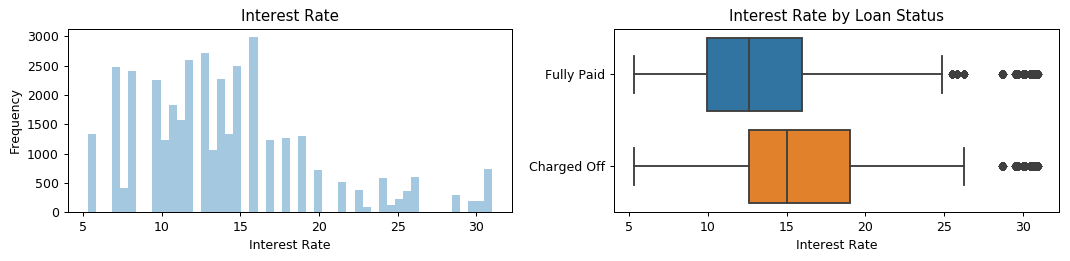

In [23]:
dataset['int_rate'] = dataset['int_rate'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['int_rate'].describe())
plot_var('int_rate', 'Interest Rate', continuous=True, dataset=dataset)

There seems to be a much higher interest rate on average for loans that charge off

### Loan Amount (Numerical)
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [24]:
print(dataset.groupby('loan_status')['loan_amnt'].describe())

               count          mean          std     min     25%      50%  \
loan_status                                                                
Charged Off   8625.0  15452.168116  9447.032934  1000.0  8000.0  14000.0   
Fully Paid   29145.0  13690.972723  9244.813927  1000.0  6400.0  11200.0   

                 75%      max  
loan_status                    
Charged Off  21000.0  40000.0  
Fully Paid   19200.0  40000.0  


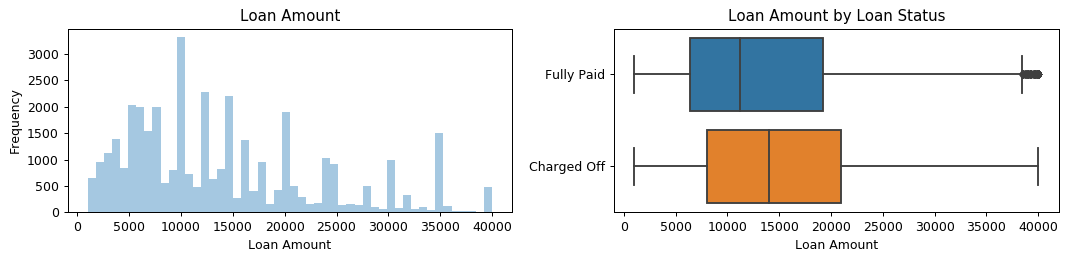

In [25]:
plot_var('loan_amnt', 'Loan Amount', continuous=True, dataset=dataset)

It seems charged off loans have a higher loan amount

### Mortgage Accounts (Numerical)
Number of mortgage accounts

loan_status  mort_acc
Charged Off  0            4295
             1            1629
             2            1193
             3             710
             4             405
             5             215
             6             108
             7              43
             8              13
             9              11
             10              3
Fully Paid   0           11003
             1            5592
             2            4767
             3            3288
             4            2163
             5            1118
             6             608
             7             290
             8             171
             10             80
             9              65
Name: mort_acc, dtype: int64


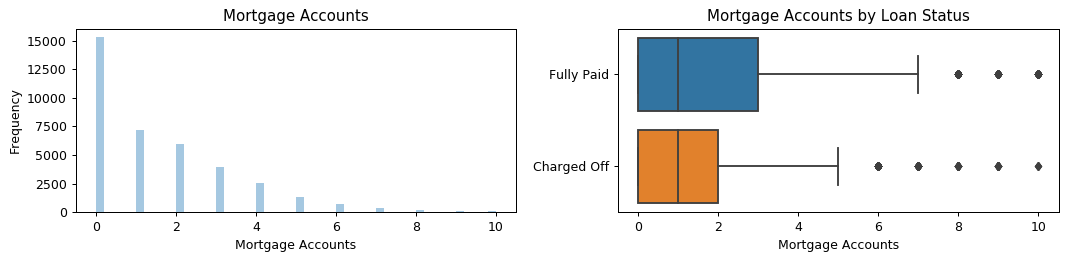

In [26]:
dataset.loc[dataset['mort_acc'] > 9, 'mort_acc'] = 10
print(dataset.groupby('loan_status')['mort_acc'].value_counts(dropna=False))
plot_var('mort_acc', 'Mortgage Accounts', continuous=True, dataset=dataset)

Currently there does not seem to be a significant difference

### Open Account (Numerical)
The number of open credit lines in the borrower's credit file.

               count       mean       std  min  25%   50%   75%   max
loan_status                                                          
Charged Off   8625.0  11.992696  5.818954  1.0  8.0  11.0  15.0  68.0
Fully Paid   29145.0  11.825630  5.743959  0.0  8.0  11.0  15.0  88.0


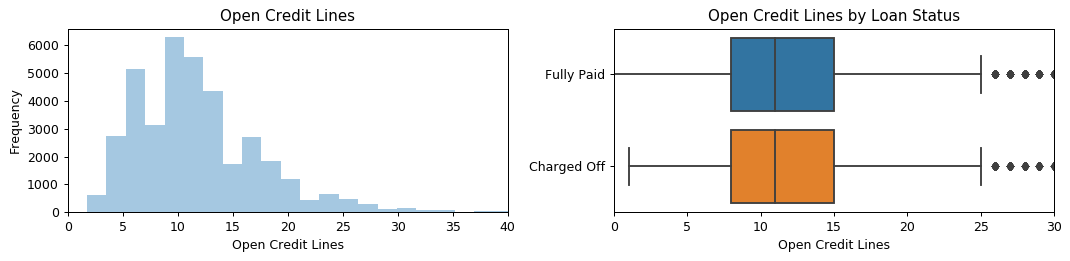

In [27]:
print(dataset.groupby('loan_status')['open_acc'].describe())
plot_var('open_acc', 'Open Credit Lines', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=30)

Does not seem to be a good indicator of risk

### Public Record (Categorical)
Number of derogatory public records

loan_status  pub_rec     
Charged Off  None             6659
             At least one     1966
Fully Paid   None            22937
             At least one     6208
Name: pub_rec, dtype: int64


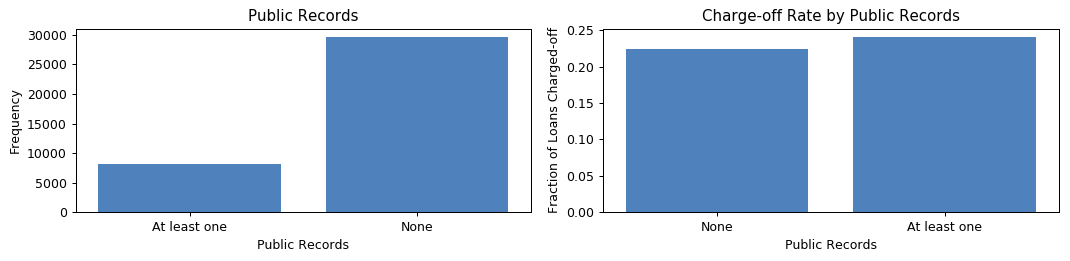

In [28]:
dataset['pub_rec'] = pd.cut(dataset['pub_rec'], [0, 0.9, 25], labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec'].value_counts(dropna=False))
plot_var('pub_rec', 'Public Records', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by derogatory public records

### Public Record of Bankruptcies (Categorical)
Number of public record bankruptcies

loan_status  pub_rec_bankruptcies
Charged Off  None                     7234
             At least one             1391
Fully Paid   None                    24732
             At least one             4413
Name: pub_rec_bankruptcies, dtype: int64


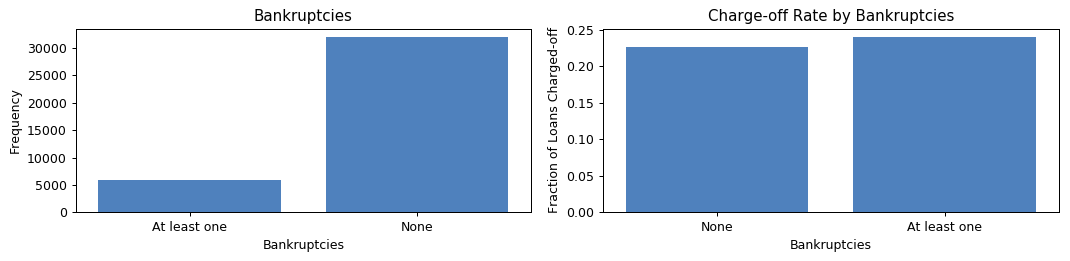

In [29]:
dataset['pub_rec_bankruptcies'] = pd.cut(dataset['pub_rec_bankruptcies'], [0, 0.9, 25], labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec_bankruptcies'].value_counts(dropna=False))
plot_var('pub_rec_bankruptcies', 'Bankruptcies', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by public bankruptcies records

### Purpose (Categorical)
A category provided by the borrower for the loan request

In [30]:
dataset.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
house                 0.155000
car                   0.175403
vacation              0.198198
home_improvement      0.198206
major_purchase        0.205184
credit_card           0.207764
debt_consolidation    0.236775
other                 0.244284
medical               0.250877
renewable_energy      0.280000
moving                0.303109
small_business        0.390110
Name: loan_status, dtype: float64

### Revolving Balance (Numerical)
Total credit revolving balance

               count          mean           std  min     25%      50%  \
loan_status                                                              
Charged Off   8625.0  15598.939362  18289.533135  0.0  6023.0  11323.0   
Fully Paid   29145.0  15601.315080  24339.574929  0.0  5176.0  10103.0   

                 75%        max  
loan_status                      
Charged Off  19085.0   354794.0  
Fully Paid   18214.0  1039013.0  
               count      mean       std  min       25%       50%       75%  \
loan_status                                                                   
Charged Off   8625.0  9.189286  1.172564  0.0  8.703507  9.334680  9.856710   
Fully Paid   29145.0  9.078444  1.308805  0.0  8.551981  9.220687  9.810001   

                   max  
loan_status             
Charged Off  12.779295  
Fully Paid   13.853783  


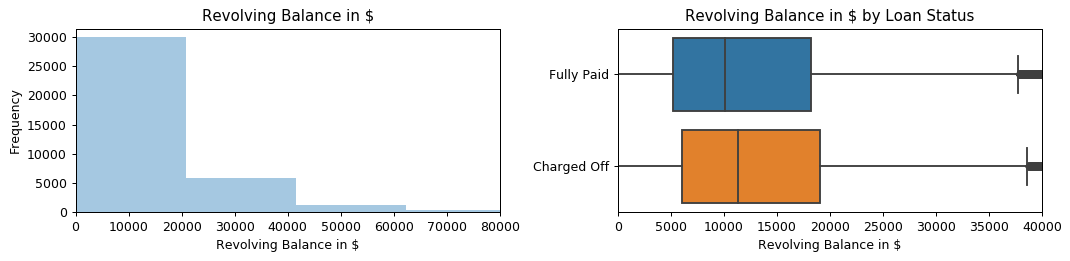

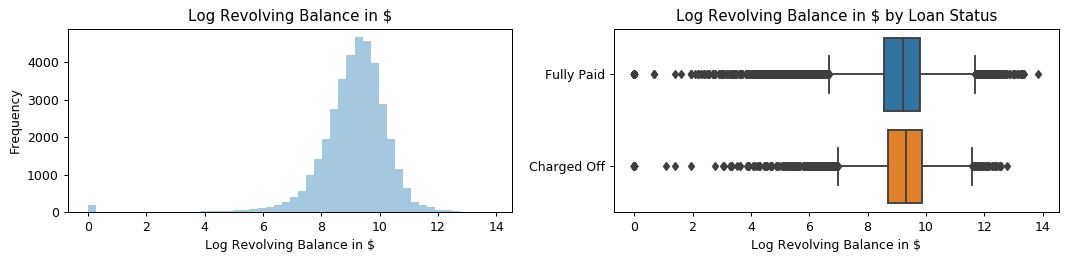

In [31]:
print(dataset.groupby('loan_status')['revol_bal'].describe())
plot_var('revol_bal', 'Revolving Balance in $', continuous=True, dataset=dataset,
                  x1limit=True, x2limit=True, x1l=0, x1u=80000, x2l=0, x2u=40000)
# Seems like the data is heavily right skewed with a large range due to large outliers so we take the log transformation
dataset['log_revol_bal'] = dataset['revol_bal'].apply(lambda x: np.log(x + 1))
dataset.drop('revol_bal', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_revol_bal'].describe())
plot_var('log_revol_bal', 'Log Revolving Balance in $', continuous=True, dataset=dataset)

There is not much difference in the two categories for revolving balances

### Revolving Utility (Numerical)
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Charged Off   8624.0  52.278154  23.940588  0.0  34.9  52.8  70.3  138.9
Fully Paid   29120.0  44.685968  24.521824  0.0  25.4  43.3  62.9  125.2


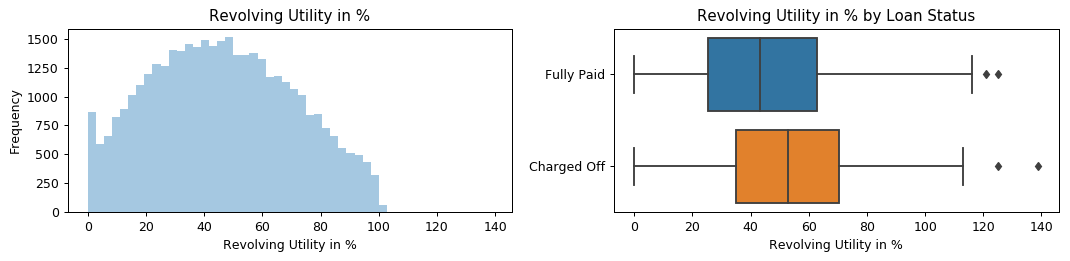

In [32]:
dataset['revol_util'] = dataset['revol_util'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['revol_util'].describe())
plot_var('revol_util', 'Revolving Utility in %', continuous=True, dataset=dataset)

It seems those with a lower revolving utility are more likely to pay off their loans

### Grade (Categorical)
LendingClub assigned loan grade. The higher the letter, the safer the loan.

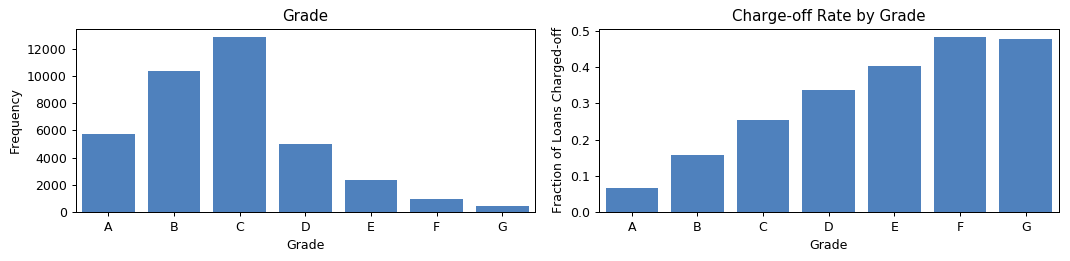

In [33]:
plot_var('grade', 'Grade', continuous=False, dataset=dataset)

There seems to be a strong trend between charge off rate and deterioriateing sub grade

### Term (Categorical)
The number of payments on the loan. Values are in months and can be either 36 or 60

loan_status  term
Charged Off  36       5846
             60       2779
Fully Paid   36      23073
             60       6072
Name: term, dtype: int64


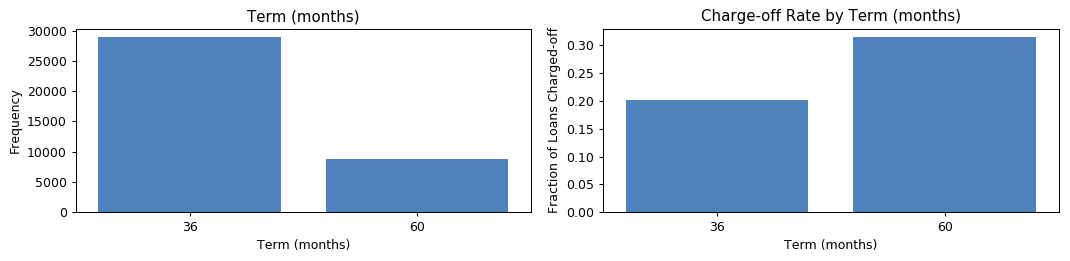

In [34]:
# dataset['term'].replace('36 months', 36, inplace=True)
# dataset['term'].replace('60 months', 60, inplace=True)
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))
print(dataset.groupby('loan_status')['term'].value_counts(dropna=False))
plot_var('term', 'Term (months)', continuous=False, dataset=dataset)

It seems longer term loans have a higher likelihood of being charged off

### Total Accounts (Numerical)
The total number of credit lines currently in the borrower's credit file

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Charged Off   8625.0  23.747362  11.761055  2.0  15.0  22.0  30.0   97.0
Fully Paid   29145.0  24.859633  12.233984  2.0  16.0  23.0  31.0  146.0


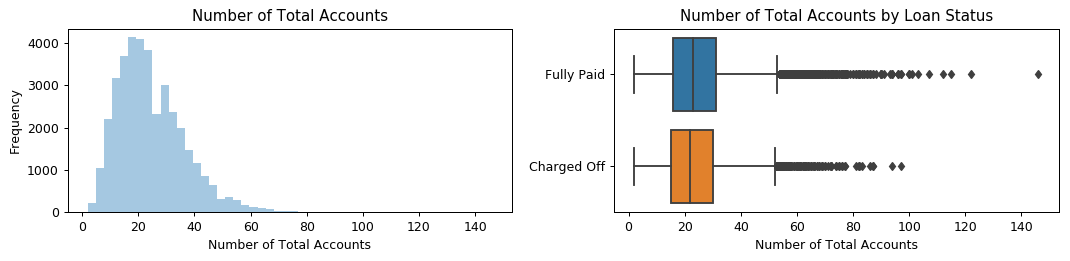

In [35]:
print(dataset.groupby('loan_status')['total_acc'].describe())
plot_var('total_acc', 'Number of Total Accounts', continuous=True, dataset=dataset)

There does not seem to be a significant difference in charge off rate depending on the total account number

### Verification Status (Categorical)
Indicates if income was verified, not verified, or if the income source was verified.

In [36]:
print(dataset.groupby('loan_status')['verification_status'].value_counts(dropna=False))

loan_status  verification_status
Charged Off  Source Verified         3584
             Verified                2986
             Not Verified            2055
Fully Paid   Source Verified        11607
             Not Verified           10330
             Verified                7208
Name: verification_status, dtype: int64


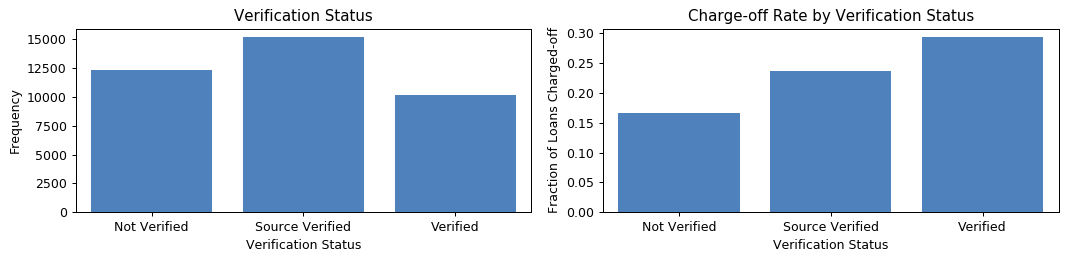

In [37]:
plot_var('verification_status', 'Verification Status', continuous=False, dataset=dataset)

There seems to be a strong linear trend between charged off rate and verification status. Surprisingly, loans with a status of verified have a higher chance of becoming charged off.

# Preliminary Model Design

### Create dummy variables
1 means charged-off and 0 means fully paid and create dummy variables for all categorical variables

In [38]:
dataset['loan_status'].replace('Charged Off', 1, inplace=True)
dataset['loan_status'].replace('Fully Paid', 0, inplace=True)

dataset = pd.get_dummies(dataset, columns=['grade', 'home_ownership', 'verification_status', 'purpose', 
                                           'initial_list_status', 'application_type', 'pub_rec', 'pub_rec_bankruptcies'], drop_first=True)
dataset.head()

,loan_amnt,term,int_rate,emp_length,loan_status,dti,delinq_2yrs,earliest_cr_line,open_acc,revol_util,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,pub_rec_At least one,pub_rec_bankruptcies_At least one
0,5000,36,7.35,5.0,0,15.76,0,2004,12,13.2,...,0,0,0,0,0,0,1,0,0,0
1,7500,36,7.35,7.0,0,13.12,0,2013,19,27.2,...,0,0,0,0,0,0,1,0,0,0
2,9600,36,7.97,0.0,0,18.34,0,2005,16,48.6,...,0,0,0,0,0,0,1,0,0,0
3,2000,36,7.07,2.0,0,12.15,0,2005,9,0.3,...,1,0,0,0,0,0,1,0,0,0
4,7200,36,24.85,2.0,0,6.07,0,2000,4,98.9,...,0,0,0,0,0,0,1,0,0,0


### Split the data

In [39]:
dataset.dropna(inplace=True)
# dataset.fillna(lambda x: x.median())
y = dataset.loc[:, dataset.columns == 'loan_status']
x = dataset.loc[:, dataset.columns != 'loan_status']
# y = dataset['loan_status']
# X = dataset.drop(columns=['loan_status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=dataset['loan_status'])
# x_train = x_train.reset_index()
# y_train = y_train.reset_index()

# Feature Selection and Model Fitting

### Logistic Regression Model

In [40]:
lr_model = LogisticRegression(penalty="l2",
                           C=0.5,
                           fit_intercept=True,
                           class_weight='balanced',
                           random_state=0,
                           max_iter=10000,
                           solver='lbfgs')
lr_model = lr_model.fit(x_train, y_train.values.ravel())
y_pred_lr = lr_model.predict(x_test)

In [41]:
print('Accuracy of base logistic regresssion on test set: {:.3f}'.format(lr_model.score(x_test, y_test)))
conf_mat = confusion_matrix(y_test, y_pred_lr)
conf_mat

Accuracy of base logistic regresssion on test set: 0.657


array([[5542, 2687],
       [ 943, 1415]], dtype=int64)

In [42]:
import statsmodels.api as sm
logit_model = sm.Logit(y, x)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.480191
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                    Logit                  Pseudo R-squared:       0.095     
Dependent Variable:       loan_status            AIC:                    33967.0325
Date:                     2019-03-03 06:04       BIC:                    34297.4120
No. Observations:         35287                  Log-Likelihood:         -16945.   
Df Model:                 38                     LL-Null:                -18714.   
Df Residuals:             35248                  LLR p-value:            0.0000    
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           7.0000                                                   
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
loan_amnt                           -0.0000   0.0000 -0.6301 0.5286 -0.0000  0.0000
term                                 0.0123   0.0016  7.4339 0.0000  0.0090  0.0155
int_rate                             0.0731   0.0116  6.2897 0.0000  0.0503  0.0958
emp_length                          -0.0151   0.0038 -4.0253 0.0001 -0.0225 -0.0077
dti                                  0.0105   0.0016  6.4157 0.0000  0.0073  0.0137
delinq_2yrs                          0.1366   0.0231  5.9160 0.0000  0.0913  0.1818
earliest_cr_line                    -0.0020   0.0002 -8.1619 0.0000 -0.0024 -0.0015
open_acc                             0.0274   0.0036  7.6357 0.0000  0.0203  0.0344
revol_util                           0.0092   0.0007 12.6652 0.0000  0.0078  0.0106
total_acc                           -0.0071   0.0018 -3.9995 0.0001 -0.0105 -0.0036
mort_acc                            -0.1008   0.0108 -9.3308 0.0000 -0.1219 -0.0796
log_annual_inc                      -0.1610   0.0356 -4.5249 0.0000 -0.2307 -0.0913
log_installment                      0.3394   0.0517  6.5690 0.0000  0.2382  0.4407
log_revol_bal                       -0.0604   0.0156 -3.8664 0.0001 -0.0910 -0.0298
grade_B                              0.4800   0.0763  6.2923 0.0000  0.3305  0.6295
grade_C                              0.6135   0.1037  5.9155 0.0000  0.4102  0.8168
grade_D                              0.5622   0.1486  3.7839 0.0002  0.2710  0.8534
grade_E                              0.3211   0.2152  1.4920 0.1357 -0.1007  0.7429
grade_F                              0.1193   0.2744  0.4349 0.6637 -0.4185  0.6572
grade_G                             -0.0839   0.2954 -0.2839 0.7765 -0.6629  0.4952
home_ownership_OWN                   0.1721   0.0465  3.7024 0.0002  0.0810  0.2632
home_ownership_RENT                  0.3366   0.0350  9.6274 0.0000  0.2681  0.4051
verification_status_Source Verified  0.1701   0.0346  4.9093 0.0000  0.1022  0.2380
verification_status_Verified         0.2459   0.0382  6.4372 0.0000  0.1710  0.3208
purpose_credit_card                  0.0058   0.1372  0.0423 0.9662 -0.2630  0.2746
purpose_debt_consolidation           0.0035   0.1343  0.0259 0.9793 -0.2598  0.2668
purpose_home_improvement             0.2496   0.1414  1.7655 0.0775 -0.0275  0.5267
purpose_house                       -0.7356   0.2613 -2.8149 0.0049 -1.2477 -0.2234
purpose_major_purchase               0.1691   0.1597  1.0589 0.2896 -0.1439  0.4821
purpose_medical                      0.2740   0.1736  1.5785 0.1144 -0.0662  0.6142
purpose_moving                       0.3550   0.1820  1.9505 0.0511 -0.0017  0.7117
purpose_other                        0.2308   0.1420  1.6253 0.1041 -0.0475  0.5091
purpose_renewable_energy             0.8100   0.5173  1.5658 0.1174 -0.2039  1.8240
purpose_small_business               0.7793   0.1778  4.3833 0.0000  0.4308  1.1277
purpose_vacation                     0

We remove all variables with p-value less than 0.05

In [43]:
result.pvalues[result.pvalues > 0.05]

loan_amnt                            0.528648
grade_E                              0.135709
grade_F                              0.663670
grade_G                              0.776495
purpose_credit_card                  0.966228
purpose_debt_consolidation           0.979323
purpose_home_improvement             0.077484
purpose_major_purchase               0.289649
purpose_medical                      0.114448
purpose_moving                       0.051116
purpose_other                        0.104100
purpose_renewable_energy             0.117397
purpose_vacation                     0.079031
initial_list_status_w                0.460733
pub_rec_At least one                 0.756315
pub_rec_bankruptcies_At least one    0.881142
dtype: float64

In [44]:
keep_list = list(result.pvalues[result.pvalues < 0.05].index)
keep_list.append('loan_status')
drop_list = [col for col in dataset.columns if col not in keep_list]
x_train = x_train.drop(labels=drop_list, axis=1)
x_test = x_test.drop(labels=drop_list, axis=1)
lr_model = LogisticRegression(penalty="l2", C=0.5, fit_intercept=True, class_weight='balanced', 
                           random_state=0, max_iter=10000, solver='lbfgs')
lr_model = lr_model.fit(x_train, y_train.values.ravel())
y_pred_lr = lr_model.predict(x_test)

### Logistic Regression Results

In [45]:
print('Accuracy of adjusted logistic regresssion on test set: {:.3f}'.format(lr_model.score(x_test, y_test)))
conf_mat = confusion_matrix(y_test, y_pred_lr)
conf_mat

Accuracy of adjusted logistic regresssion on test set: 0.637


array([[5130, 3099],
       [ 739, 1619]], dtype=int64)

In [46]:
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

F1 Score: 0.4576031656302996
              precision    recall  f1-score   support

           0       0.87      0.62      0.73      8229
           1       0.34      0.69      0.46      2358

   micro avg       0.64      0.64      0.64     10587
   macro avg       0.61      0.66      0.59     10587
weighted avg       0.76      0.64      0.67     10587



### Random Forest Model

In [47]:
rf_model_path = '.\\data\\rf_1000.joblib'
if os.path.exists(rf_model_path):
    forest = load('.\\data\\rf_1000.joblib')
else:
    # from Class 4
    n_trees = [50, 100, 250, 500, 1000, 1500, 2500]
    rf_dict = dict.fromkeys(n_trees)
    for num in n_trees:
        print(num)
        rf = RandomForestClassifier(n_estimators=num,
                                    min_samples_leaf=30,
                                    oob_score=True,
                                    random_state=100,
                                    class_weight='balanced',
                                    n_jobs=2)
        rf.fit(x_train, y_train.values.ravel())
        rf_dict[num] = rf

    oob_error_list = [None] * len(n_trees)

    for i in range(len(n_trees)):
        oob_error_list[i] = 1 - rf_dict[n_trees[i]].oob_score_

    plt.plot(n_trees, oob_error_list, 'bo', n_trees, oob_error_list, 'k')
    # Save model to file
    dump(rf_dict[1000], '.\\data\\rf_1000.joblib')
    forest = rf_dict[1000]
y_pred_rf = forest.predict(x_test)

### Random Forest Results

In [48]:
print('Accuracy of Random Forest on test set: {:.3f}'.format(forest.score(x_test, y_test)))
conf_mat = confusion_matrix(y_test, y_pred_rf)
conf_mat

Accuracy of Random Forest on test set: 0.673


array([[5678, 2551],
       [ 914, 1444]], dtype=int64)

In [49]:
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

F1 Score: 0.45458838344089403
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      8229
           1       0.36      0.61      0.45      2358

   micro avg       0.67      0.67      0.67     10587
   macro avg       0.61      0.65      0.61     10587
weighted avg       0.75      0.67      0.70     10587



### Neural Network Model

In [50]:
scaler = StandardScaler()
scaler.fit(x_train.astype('float64'))
StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_nn = scaler.transform(x_train.astype('float64'))
x_test_nn = scaler.transform(x_test.astype('float64'))

nn_model_path = '.\\data\\nn_model.joblib'
if os.path.exists(nn_model_path):
    mlp = load('.\\data\\nn_model.joblib')
else:
    mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=0)
    mlp.fit(x_train_nn, y_train.values.ravel())
    dump(mlp, '.\\data\\nn_model.joblib')
y_pred_nn = mlp.predict(x_test_nn)

### Neural Network Results

In [51]:
print('Accuracy of Neural Network on test set: {:.3f}'.format(mlp.score(x_test_nn, y_test)))
conf_mat = confusion_matrix(y_test, y_pred_nn)
conf_mat

Accuracy of Neural Network on test set: 0.773


array([[7859,  370],
       [2032,  326]], dtype=int64)

In [52]:
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

F1 Score: 0.21349050425671245
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      8229
           1       0.47      0.14      0.21      2358

   micro avg       0.77      0.77      0.77     10587
   macro avg       0.63      0.55      0.54     10587
weighted avg       0.72      0.77      0.72     10587



### Ensembled Model

In [53]:
# RF_probs = pd.DataFrame(forest.predict_proba(x_test))
# LR_probs = pd.DataFrame(lr_model.predict_proba(x_test))
# probs
ensemble_model_path = '.\\data\\ensemble_model.joblib'
if os.path.exists(ensemble_model_path):
    ensemble = load('.\\data\\ensemble_model.joblib')
else:
    estimators = [('log_reg', lr_model), ('rf', forest)]
    ensemble = VotingClassifier(estimators, voting='soft', n_jobs=2)
    ensemble.fit(x_train, y_train.values.ravel())
    # Save model to file
    dump(ensemble, '.\\data\\ensemble_model.joblib')
y_pred_ensemble = ensemble.predict(x_test)

### Ensembled Results

In [54]:
conf_mat = confusion_matrix(y_test, y_pred_ensemble)
print(conf_mat)
print('Accuracy of ensemble on test set: {:.3f}'.format(ensemble.score(x_test, y_test.values.ravel())))

[[5413 2816]
 [ 838 1520]]
Accuracy of ensemble on test set: 0.655


# Production Use

### Input and Output Spec
* Input: pandas dataframe containing:
 * loan_status (Outcome)
 * Annual Income, Application Type, Debt to Income Ratio, Delinquincy, Earliest Credit Line, Employment Length, Home Ownership, Initial List Status, Installment, Interest Rate, Loan Amount, Mortgage Accounts, Open Account, Public Record, Public Record of Bankruptices, Purpose, Revolving Balance, Revolving Utility, Grade, Term, Total Accounts, Verification Status (Predictors)
* Outcome: list of same size as number of rows in pandas DataFrame containing:
 * 1/0 for predicted loan status of fully paid or charged off
 * Probability for each category


In [55]:
input_data = pd.DataFrame(columns=['loan_amnt', 'term', 'int_rate', 'installment', 
                                   'grade', 'emp_length', 'home_ownership', 'annual_inc', 
                                   'verification_status', 'purpose', 'dti', 'delinq_2yrs', 
                                   'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 
                                   'revol_util', 'total_acc', 'initial_list_status', 'application_type', 
                                   'mort_acc', 'pub_rec_bankruptcies'])
input_data.loc[0] = pd.Series({'loan_amnt':12000, 
                               'term':'36 months', 
                               'int_rate': '7.00%', 
                               'installment': 350, 
                               'grade': 'A', 
                               'emp_length': '3 years', 
                               'home_ownership': 'RENT', 
                               'annual_inc': 30000, 
                               'verification_status': 'Source Verified', 
                               'purpose': 'major_purchase', 
                               'dti': 15.23, 'delinq_2yrs': 0, 
                               'earliest_cr_line': 'Jul-17', 
                               'open_acc': 3, 
                               'pub_rec': 0, 
                               'revol_bal': 18000, 
                               'revol_util': '17.24%', 
                               'total_acc': 3, 
                               'initial_list_status': 'w', 
                               'application_type': 'Individual', 
                               'mort_acc': 0, 
                               'pub_rec_bankruptcies': 0})


In [56]:
input_data

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,12000,36 months,7.00%,350,A,3 years,RENT,30000,Source Verified,major_purchase,...,Jul-17,3,0,18000,17.24%,3,w,Individual,0,0


In [57]:
input_data['log_annual_inc'] = input_data['annual_inc'].apply(lambda x: np.log(x + 1))
input_data.drop('annual_inc', axis=1, inplace=True)

input_data['delinq_2yrs'].values[input_data['delinq_2yrs'] > 1] = 2

input_data['earliest_cr_line'] = input_data['earliest_cr_line'].apply(lambda s: int(s[-2:]))
input_data.loc[input_data['earliest_cr_line'] > 20, 'earliest_cr_line'] += 1900
input_data.loc[input_data['earliest_cr_line'] < 20, 'earliest_cr_line'] += 2000

input_data['emp_length'].replace('< 1 year', 0, inplace=True)
input_data['emp_length'].replace('1 year', 1, inplace=True)
input_data['emp_length'].replace('2 years', 2, inplace=True)
input_data['emp_length'].replace('3 years', 3, inplace=True)
input_data['emp_length'].replace('4 years', 4, inplace=True)
input_data['emp_length'].replace('5 years', 5, inplace=True)
input_data['emp_length'].replace('6 years', 6, inplace=True)
input_data['emp_length'].replace('7 years', 7, inplace=True)
input_data['emp_length'].replace('8 years', 8, inplace=True)
input_data['emp_length'].replace('9 years', 9, inplace=True)
input_data['emp_length'].replace('10+ years', 10, inplace=True)

input_data['log_installment'] = input_data['installment'].apply(lambda x: np.log(x + 1))
input_data.drop('installment', axis=1, inplace=True)

input_data['int_rate'] = input_data['int_rate'].str.rstrip('%').astype('float')

input_data.loc[dataset['mort_acc'] > 9, 'mort_acc'] = 10

input_data['pub_rec'] = pd.cut(input_data['pub_rec'], [0, 0.9, 25], 
                               labels=['None', 'At least one'], include_lowest=True)

input_data['pub_rec_bankruptcies'] = pd.cut(input_data['pub_rec_bankruptcies'], [0, 0.9, 25], 
                                            labels=['None', 'At least one'], include_lowest=True)

input_data['log_revol_bal'] = input_data['revol_bal'].apply(lambda x: np.log(x + 1))
input_data.drop('revol_bal', axis=1, inplace=True)

input_data['revol_util'] = input_data['revol_util'].str.rstrip('%').astype('float')

input_data['term'] = input_data['term'].apply(lambda s: np.int8(s.split()[0]))

In [58]:
# TODO: we must create a dummy dataset with all types of categorical values then get dummies and use only the first one!
input_data = pd.get_dummies(input_data, columns=['grade', 'home_ownership', 'verification_status', 'purpose', 
                                           'initial_list_status', 'application_type', 'pub_rec', 'pub_rec_bankruptcies'], drop_first=True)

dummy_frame = pd.DataFrame(columns=['term', 'int_rate', 'emp_length', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'revol_util', 'total_acc', 'mort_acc',
       'log_annual_inc', 'log_installment', 'log_revol_bal', 'grade_B',
       'grade_C', 'grade_D', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_house', 'purpose_small_business',
       'application_type_Joint App'])
input_data=input_data.reindex(columns = dummy_frame.columns, fill_value=0)

In [59]:
input_data

,term,int_rate,emp_length,dti,delinq_2yrs,earliest_cr_line,open_acc,revol_util,total_acc,mort_acc,...,grade_B,grade_C,grade_D,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_house,purpose_small_business,application_type_Joint App
0,36,7.0,3,15.23,0,2017,3,17.24,3,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
prod_model = load('.\\data\\ensemble_model.joblib')
output = prod_model.predict(input_data)
if output[0] == 0:
    print('Fully Paid')
else:
    print('Charged Off')

Fully Paid


In [61]:
p_output = pd.DataFrame(prod_model.predict_proba(input_data))
p_output.columns = ['Fully Paid', 'Charged Off']
p_output = (p_output*100).round(0).astype(int).astype(str) + '%'

In [62]:
p_output

,Fully Paid,Charged Off
0,81%,19%


# Next Steps and Further Research

* Improve performance of current models
* Look into other ML models
* Improvemnts to feature selection
* Opportunity cost of prediction errors

#### Hw 2
The business question we try to solve as well as the goal of this analysis, is to leverage loan data to be able to predict whether or not a potential debtor will charge off(default) or fully pay their debt. Ultimately, we want to be able to analyze the risk of a given loan before it is given and advise the potential crediting association. Each row in the data table consists of loan information about debtors with about 37770 total rows. Initially, the dataset had 150 columns, however, after cleaning the data by filtering out columns on missing values criteria, relevance of information, and columns would be information obtained after money has already been loaned, there was 24 columns in the end. For example, some columns have over 50% of missing values. I set the cut off for dropping a column if it contained 15% or more missing values. Afterwards, I manually looked through the columns and picked out ones that were the most relevant and dropped columns that did not provide useful information. For example, job title was dropped since there were too many unique job title values to be of any use. From here, I looked at the summary statistics and plot to see if any had a strong correlation to the response variable. There are some trends between the certain predictors and the response. Some predictors tend to have a higher mean for one response than the other. In particular, some significant ones to explore further are loan amount, interest rate, and public records. Loan amount, installment, and interest rate both showed higher averages for loans that were higher risk. Public records showed those with more public records also had a higher probability of defaulting. Some of the data for these predictors were right skewed, such as installment, so some processing was made to make it more normal by taking the natural log of the data. In some of the data such as, delinquency, not all categories have a good frequency so perhaps some categories can be combined together determined by some threshold. There are two classification techniques I would like to consider and compare their performance, logistic regression and random forest.

#### Hw 3
Feature Selection was based on intuitive knowledge as mentioned previously as well as looking at the p-values of the logistic regression. Interestingly, some variables that I initially thought would be good predictors ended up having p-values of over 0.05 meaning insignificant. For example, loan amount and interest rate, based on the initial exploratory analysis showed to have an higher average in charged off rate but ended up being dropped due to a high p-value. Comparing the results of the two models, the confusion matrix of the logistic regression model shows that there are 5094+1627 = 6721 correct predictions and 5094+1627 = 3866 incorrect predictions which results in an accuracy of about 63.5%. Alternatively, the confusion matrix of the random forest model shows that there are 5768 + 1381 = 7149 correct predictions and 2461+977 = 3438 incorrect predictions which results in an accuracy of about 67.5%. There is therefore not much different between the accuracies of the two different methods. Random Forest does however, take much longer to run than logistic regression. Therefore, the preferred model is logistic regression by the confusion matrix evaluation. Overall, this seems to be an acceptable accuracy level.

##### Hw 4
The data file is about 5mb consists of 37770 rows and 23 columns. When reading it in with pandas, it only takes about 500ms which is quite fast. Therefore, it seems unnessary to make an effort to improve the speed of data reading. Before the data is read, columns that would not be used and other excess data was filtered out. Before computation is made on the data, columns that were decided to not be used, such as columns with a enormous amount of missing data or columns that does not provivde valuable information, were dropped. In some places where a for loop could have bee used, apply() was leveraged instead. Overall, the portion of the code that takes the most computation time is the random forest model which takes around 3 minutes to complete. However, this only needs to be run once and then the model can be saved and loaded. Are applying parallel processing, the computation time was greatly reduced. Previously the computation took over 10 minutes, now it takes about 4 minutes.

In [ ]:
!jupyter nbconvert presentation.ipynb --to slides --post serve